<a href="https://colab.research.google.com/github/ClaudioH19/TareasML/blob/master/PROYECTO_FINAL/Notebooks/etapa_1_proyecto_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FASE 0: Importar datos desde el drive y crear el CSV curado con gdown y pandas**

Se instala gdown para descargar desde google drive y descomprimir el zip

In [1]:
# Instalar gdown para descargar desde Google Drive
!pip install -q gdown

# Descargar el ZIP desde Drive
import gdown
zip_id = "1g_FI6gG1LClmoMuIm4_QG60NKp4q7yjE"
gdown.download(f"https://drive.google.com/uc?id={zip_id}", "ecg_signals.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1g_FI6gG1LClmoMuIm4_QG60NKp4q7yjE
From (redirected): https://drive.google.com/uc?id=1g_FI6gG1LClmoMuIm4_QG60NKp4q7yjE&confirm=t&uuid=4c8e9e00-7030-45e7-ad24-0d69bba2f9cf
To: /content/ecg_signals.zip
100%|██████████| 99.2M/99.2M [00:01<00:00, 50.0MB/s]


'ecg_signals.zip'

In [2]:
# Descomprimir el archivo ZIP
import zipfile
import os

with zipfile.ZipFile("ecg_signals.zip", 'r') as zip_ref:
    zip_ref.extractall("ecg_data")

# Listar algunos archivos para verificar
os.listdir("ecg_data/training2017")[:10]

['A03778.hea',
 'A01276.hea',
 'A04197.hea',
 'A03349.hea',
 'A01832.mat',
 'A05630.hea',
 'A00669.mat',
 'A02219.mat',
 'A01018.hea',
 'A08061.hea']

Veremos al distribución de clases

In [6]:
# prompt: Contar y mostrar el número de cada clase del dataset usando el reference.csv

import pandas as pd

# Cargar el archivo reference.csv
reference_df = pd.read_csv('ecg_data/training2017/REFERENCE.csv', header=None, names=['filename', 'class'])

# Contar el número de instancias por clase
class_counts = reference_df['class'].value_counts()

# Mostrar los resultados
print("Número de instancias por clase:")
class_counts

Número de instancias por clase:


,count
class,
N,5050
O,2456
A,738
~,284


Como se busca resolver un problema de clasificación binaria se usará el siguiente enfoque: Agruparemos los O y los A en una categoría "A" que represente Anormal, y se eliminarán los datos noisy para no impactar el rendimiento.

In [7]:
# prompt: #Eliminar del dataset y del reference los datos noisy denotados por ~, y convertir los datos O en datos A

# Filtrar las filas que no contienen '~' en la columna 'class'
reference_df_cleaned = reference_df[reference_df['class'] != '~'].copy()

# Reemplazar 'O' por 'A' en la columna 'class'
reference_df_cleaned['class'] = reference_df_cleaned['class'].replace('O', 'A')

# Ahora se puede reference_df_cleaned para obtener la lista de archivos de datos a procesar
# Eliminar los archivos de datos correspondientes a las filas eliminadas (los que contenían '~')
# Obtener la lista de nombres de archivo a mantener
files_to_keep = reference_df_cleaned['filename'].tolist()

# Ruta a la carpeta que contiene los archivos .mat
data_dir = 'ecg_data/training2017'

# Listar todos los archivos .mat en el directorio de datos
all_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]

# Identificar los archivos que deben ser eliminados
files_to_remove = [f for f in all_files if f.replace('.mat', '') not in files_to_keep]

# Eliminar los archivos no deseados del sistema de archivos
for file_name in files_to_remove:
    file_path = os.path.join(data_dir, file_name)
    try:
        os.remove(file_path)
        # print(f"Eliminado archivo: {file_name}") # Opcional: para ver qué archivos se eliminan
    except OSError as e:
        print(f"Error al eliminar archivo {file_name}: {e}")

# Verificar la distribución de clases después de la limpieza y re-etiquetado
print("\nNúmero de instancias por clase después de la limpieza y re-etiquetado:")
print(reference_df_cleaned['class'].value_counts())

# Ahora `reference_df_cleaned` y la carpeta `ecg_data/training2017` contienen solo los datos limpios y re-etiquetados.


Número de instancias por clase después de la limpieza y re-etiquetado:
class
N    5050
A    3194
Name: count, dtype: int64


Se observa un problema de desbalance de clases, como necesitamos generar un dataset exportable con clases balanceadas para entrenar un modelo ML, se usará submuestreo para balancear el conjunto eliminando datos de la clase mayoritaria N

In [8]:
# prompt: Eliminar clase N, para balancear el dataset por submuestreo

# Contar las instancias de cada clase
class_counts = reference_df_cleaned['class'].value_counts()

# Identificar la clase mayoritaria (N) y la minoritaria (A)
major_class = class_counts.idxmax()
minor_class = class_counts.idxmin()

# Número de instancias en la clase minoritaria (este será el tamaño deseado para ambas clases)
minor_class_count = class_counts[minor_class]

# Submuestrear la clase mayoritaria
df_major = reference_df_cleaned[reference_df_cleaned['class'] == major_class].sample(minor_class_count, random_state=42)

# Combinar el dataframe submuestreado de la clase mayoritaria con el dataframe de la clase minoritaria
reference_df_balanced = pd.concat([df_major, reference_df_cleaned[reference_df_cleaned['class'] == minor_class]])

# Opcional: Barajar el dataframe combinado para mezclar las instancias
reference_df_balanced = reference_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la distribución de clases después del submuestreo
print("\nNúmero de instancias por clase después del submuestreo:")
print(reference_df_balanced['class'].value_counts())

# Ahora `reference_df_balanced` contiene un conjunto de datos balanceado.
# Se procede a eliminar los archivos .mat correspondientes a las instancias que fueron eliminadas
# durante el submuestreo de la clase mayoritaria.

# Obtener la lista de nombres de archivo a mantener en el conjunto balanceado
files_to_keep_balanced = reference_df_balanced['filename'].tolist()

# Obtener la lista de nombres de archivo que estaban en reference_df_cleaned pero no en reference_df_balanced
files_to_remove_from_major = [f for f in reference_df_cleaned[reference_df_cleaned['class'] == major_class]['filename'].tolist() if f not in files_to_keep_balanced]

# Ruta a la carpeta que contiene los archivos .mat
data_dir = 'ecg_data/training2017'

# Eliminar los archivos no deseados del sistema de archivos
print(f"\nEliminando {len(files_to_remove_from_major)} archivos de la clase mayoritaria para balancear el dataset...")
for file_name in files_to_remove_from_major:
    file_path = os.path.join(data_dir, file_name + '.mat') # Agregar la extensión .mat
    try:
        os.remove(file_path)
        # print(f"Eliminado archivo: {file_name}.mat") # Opcional: para ver qué archivos se eliminan
    except OSError as e:
        print(f"Error al eliminar archivo {file_name}.mat: {e}")

print("Proceso de submuestreo y eliminación de archivos completado.")
print(f"El dataframe balanceado `reference_df_balanced` contiene {len(reference_df_balanced)} instancias.")
# Ahora `reference_df_balanced` y la carpeta `ecg_data/training2017` contienen los datos balanceados.


Número de instancias por clase después del submuestreo:
class
N    3194
A    3194
Name: count, dtype: int64

Eliminando 1856 archivos de la clase mayoritaria para balancear el dataset...
Proceso de submuestreo y eliminación de archivos completado.
El dataframe balanceado `reference_df_balanced` contiene 6388 instancias.


Visualización de las señales resultantes

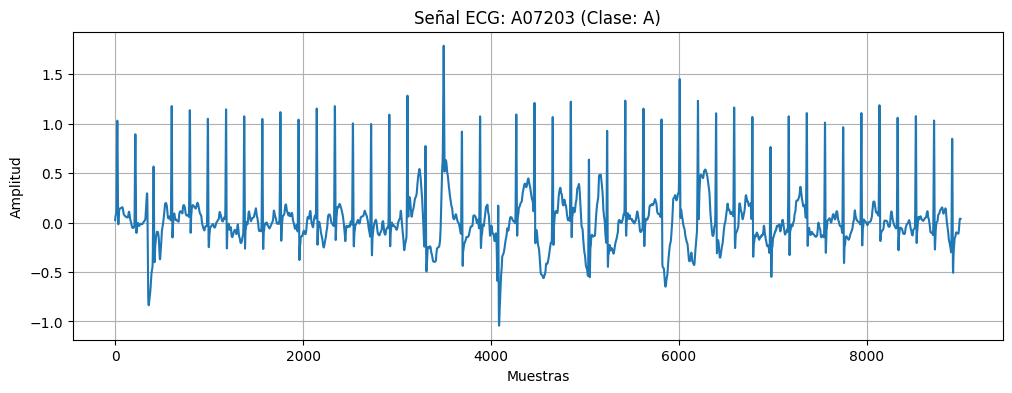

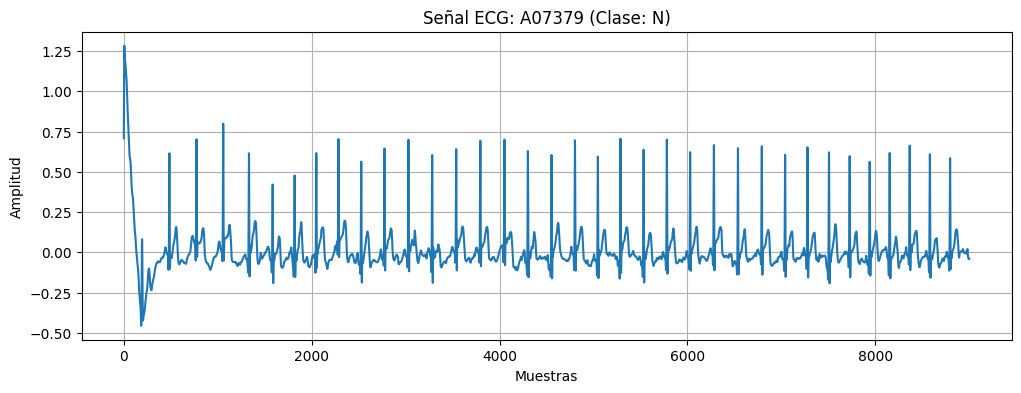

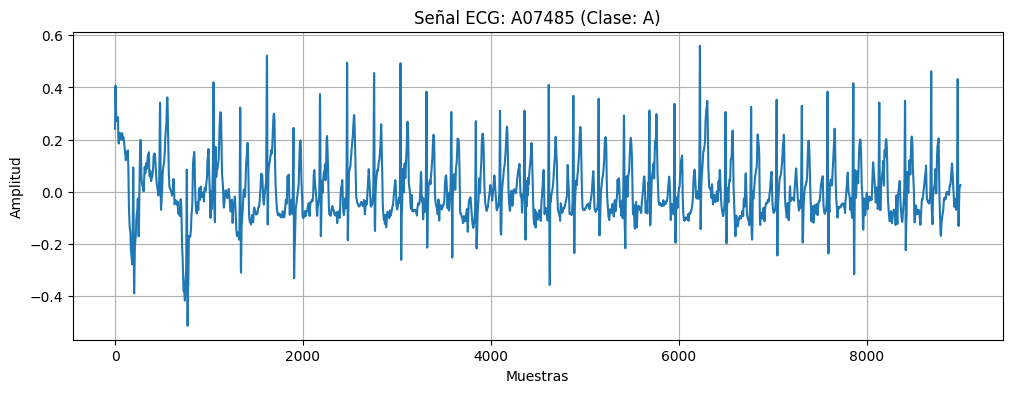

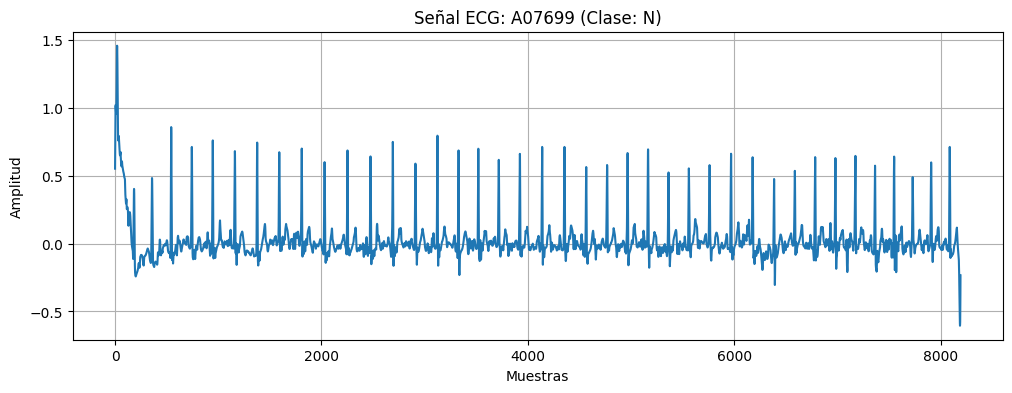

Visualización de señales completada.


In [16]:
# prompt: Visualizar 2 señales de cada tipo al azar amplitud versus tiempo una después de otra para no solapar vistas

import wfdb
import matplotlib.pyplot as plt
import random

# Separar los filenames por clase
class_N_files = reference_df_balanced[reference_df_balanced['class'] == 'N']['filename'].tolist()
class_A_files = reference_df_balanced[reference_df_balanced['class'] == 'A']['filename'].tolist()

# Seleccionar 2 archivos al azar de cada clase
selected_N_files = random.sample(class_N_files, 2)
selected_A_files = random.sample(class_A_files, 2)

# Combinar los archivos seleccionados y barajarlos
selected_files = selected_N_files + selected_A_files
random.shuffle(selected_files)

# Ruta base a los archivos .mat
base_dir = 'ecg_data/training2017/'

# Visualizar las señales una tras otra
for filename in selected_files:
    try:
        # Cargar el registro (señal y metadata)
        record = wfdb.rdrecord(base_dir + filename)

        # Obtener la señal (primera columna si hay múltiples) y el tiempo
        signal = record.p_signal[:, 0]
        time = record.d_signal[:, 0] / record.fs if record.d_signal is not None else range(len(signal))

        # Obtener la clase de la señal
        signal_class = reference_df_balanced[reference_df_balanced['filename'] == filename]['class'].iloc[0]

        # Crear la figura y los ejes para la visualización
        plt.figure(figsize=(12, 4))
        plt.plot(signal)
        plt.title(f'Señal ECG: {filename} (Clase: {signal_class})')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.show() # Mostrar la figura actual antes de pasar a la siguiente

    except Exception as e:
        print(f"Error al procesar o visualizar el archivo {filename}: {e}")

print("Visualización de señales completada.")

Extraemos las características:
- registro
- fs
- duracion_seq
- media_mv
- mstd_mV
- skewness
- kurtosis
- rr_mean_s
- rr_std_s

Para crear el .csv curado, se incorpora un filtro bandpass para **eliminar ruido** de baja frecuencia y alta frecuencia, mejorando así la detección de los picos R. Esto permite obtener intervalos RR más precisos y reducir errores causados por artefactos, lo que permite obtener resultados más fieles a la variabilidad del ritmo cardíaco.

In [19]:
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os
from scipy.signal import butter, filtfilt

# Ruta base
base_path = "ecg_data/training2017"

# Función de filtro paso banda
def bandpass_filter(signal, fs=300, low=0.5, high=40, order=2):
    nyquist = 0.5 * fs
    lowcut = low / nyquist
    highcut = high / nyquist
    b, a = butter(order, [lowcut, highcut], btype='band')
    return filtfilt(b, a, signal)

# Función para extraer características de una señal
def compute_rr_features(signal, fs=300):
    # Filtro paso banda para limpiar ruido
    signal = bandpass_filter(signal, fs)

    # Detección de picos más robusta
    peaks, _ = find_peaks(signal, distance=fs*0.3, prominence=100, height=200)

    if len(peaks) < 2:
        return None

    rr_intervals = np.diff(peaks) * (1000 / fs)  # ms

    # Eliminar RR extremos que podrían ser errores
    rr_intervals = rr_intervals[(rr_intervals > 300) & (rr_intervals < 2000)]

    if len(rr_intervals) < 2:
        return None

    # Características adicionales
    duracion_seq = len(signal) / fs  # Duración de la secuencia en segundos
    media_mv = np.mean(signal) * 1000  # Media de la señal en mV
    mstd_mV = np.std(signal) * 1000   # Desviación estándar en mV
    rr_mean_s = np.mean(rr_intervals) / 1000  # Promedio de RR en segundos
    rr_std_s = np.std(rr_intervals) / 1000    # Desviación estándar de RR en segundos

    return {
        'registro': str(peaks[0]),  # Usamos el primer pico como ID
        'fs': fs,
        'duracion_seq': duracion_seq,
        'media_mv': media_mv,
        'mstd_mV': mstd_mV,
        'skewness': skew(rr_intervals),
        'kurtosis': kurtosis(rr_intervals),
        'rr_mean_s': rr_mean_s,
        'rr_std_s': rr_std_s,
    }

# Lista para guardar resultados
records = []

# Iterar sobre el dataframe balanceado
for _, row in reference_df_balanced.iterrows():
    record_id = row['filename']  # Usamos el nombre del archivo como ID
    label = 'Normal' if row['class'] == 'N' else 'Anormal'  # Etiquetamos las clases
    mat_path = os.path.join(base_path, f"{record_id}.mat")

    try:
        mat = loadmat(mat_path)
        signal = mat['val'][0]
        features = compute_rr_features(signal)
        if features:
            features['id'] = record_id
            features['label'] = label
            records.append(features)
    except Exception as e:
        print(f"Error en {record_id}: {e}")

# Crear DataFrame con los resultados
curado_df = pd.DataFrame(records)

# Reordenar columnas para que coincidan con las características que quieres
curado_df = curado_df[['id', 'registro', 'fs', 'duracion_seq', 'media_mv', 'mstd_mV', 'skewness', 'kurtosis', 'rr_mean_s', 'rr_std_s', 'label']]

# Guardar el DataFrame como un CSV
curado_df.to_csv("ecg_rr_features_curado_final.csv", index=False)

print("Proceso completado. El archivo CSV con las características se ha guardado.")


/tmp/ipython-input-19-3590469648.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(rr_intervals),
/tmp/ipython-input-19-3590469648.py:53: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(rr_intervals),


Proceso completado. El archivo CSV con las características se ha guardado.


# **FASE 1: Inspección del dataset, visualización de distribuciones y conclusiones**

Comenzamos cargando el dataset generado (el cual fue subido a google drive)
bajo id: 1Nje52iHziTZQ1rBZIP5dSl5x8Pcaa9Po

In [23]:
# prompt: descargar desde google drive el ecg_rr_features_curado_final.csv con id 1Nje52iHziTZQ1rBZIP5dSl5x8Pcaa9Po

# Descargar el archivo CSV curado desde Google Drive
file_id = "1Nje52iHziTZQ1rBZIP5dSl5x8Pcaa9Po"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "ecg_rr_features_curado_final.csv", quiet=False)

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv("ecg_rr_features_curado_final.csv")

# Mostrar las primeras filas del DataFrame para verificar la carga
curado_df.head()

Downloading...
From: https://drive.google.com/uc?id=1Nje52iHziTZQ1rBZIP5dSl5x8Pcaa9Po
To: /content/ecg_rr_features_curado_final.csv
100%|██████████| 879k/879k [00:00<00:00, 72.2MB/s]


,id,registro,fs,duracion_seq,media_mv,mstd_mV,skewness,kurtosis,rr_mean_s,rr_std_s,label
0,A01348,57,300,30.0,735.254007,310313.743963,-1.231753,-0.232143,0.820000,0.236288,Normal
1,A06630,76,300,60.0,-746.027887,161295.726453,-1.535039,4.487984,0.862319,0.153698,Anormal
2,A01868,91,300,30.0,1405.374751,336726.213768,-4.168619,15.886332,0.730583,0.083785,Normal
3,A04904,220,300,30.0,-155.614626,98189.005949,0.173177,-1.632677,1.124487,0.500370,Anormal
4,A02311,90,300,30.0,543.214706,145482.725942,1.526648,4.809847,0.644638,0.032014,Anormal


Inspección básica:

In [26]:
# Tipos de datos por columna
print("Tipos de datos:")
print(df.dtypes)

# Conteo por clase
print("\nDistribución de clases:")
print(df['label'].value_counts())

# Estadísticas básicas
print("\nDescripción estadística:")
print(df.describe())

# Estadísticas básicas
# Describe para cada clase por separado
normal_stats = df[df['label'] == 'Normal'].describe()
afib_stats = df[df['label'] == 'Anormal'].describe()

# Renombrar columnas para claridad
normal_stats.columns = [f"{col}_Normal" for col in normal_stats.columns]
afib_stats.columns = [f"{col}_Anormal" for col in afib_stats.columns]

# Combinar ambos DataFrames horizontalmente
descripcion_por_clase = pd.concat([normal_stats, afib_stats], axis=1)

# Mostrar
print("Descripción estadística por clase:\n")
display(descripcion_por_clase)




Tipos de datos:
id               object
registro          int64
fs                int64
duracion_seq    float64
media_mv        float64
mstd_mV         float64
skewness        float64
kurtosis        float64
rr_mean_s       float64
rr_std_s        float64
label            object
dtype: object

Distribución de clases:
label
Anormal    3100
Normal     3058
Name: count, dtype: int64

Descripción estadística:
          registro      fs  duracion_seq      media_mv       mstd_mV  \
count  6158.000000  6158.0   6158.000000   6158.000000  6.158000e+03   
mean    132.711270   300.0     33.088843     17.831102  1.906987e+05   
std     271.421606     0.0     11.052537   2304.862565  1.003146e+05   
min       3.000000   300.0      9.126667 -29001.455411  3.983048e+04   
25%      33.000000   300.0     30.000000   -742.435699  1.278831e+05   
50%      87.000000   300.0     30.000000     58.822723  1.658264e+05   
75%     170.000000   300.0     30.000000    847.913229  2.227718e+05   
max    6952.000

,registro_Normal,fs_Normal,duracion_seq_Normal,media_mv_Normal,mstd_mV_Normal,skewness_Normal,kurtosis_Normal,rr_mean_s_Normal,rr_std_s_Normal,registro_Anormal,fs_Anormal,duracion_seq_Anormal,media_mv_Anormal,mstd_mV_Anormal,skewness_Anormal,kurtosis_Anormal,rr_mean_s_Anormal,rr_std_s_Anormal
count,3058.000000,3058.0,3058.000000,3058.000000,3.058000e+03,3057.000000,3057.000000,3058.000000,3058.000000,3100.000000,3100.0,3100.000000,3100.000000,3.100000e+03,3100.000000,3100.000000,3100.000000,3100.000000
mean,133.822433,300.0,32.244780,-16.335577,1.925865e+05,-0.532523,4.548989,0.849925,0.140261,131.615161,300.0,33.921470,51.534877,1.888365e+05,-0.012600,3.425147,0.805444,0.176752
std,293.419193,0.0,9.994466,2511.484634,9.942564e+04,1.937086,8.064046,0.140961,0.114170,247.859436,0.0,11.948595,2080.899091,1.011654e+05,1.720626,7.712981,0.203609,0.114902
min,3.000000,300.0,9.140000,-29001.455411,4.313424e+04,-7.511910,-2.000000,0.393644,0.000000,3.000000,300.0,9.126667,-14829.012289,3.983048e+04,-7.403945,-2.000000,0.321812,0.001667
25%,34.000000,300.0,30.000000,-818.555538,1.285100e+05,-1.622724,-0.493896,0.749868,0.048762,31.750000,300.0,30.000000,-670.585104,1.270601e+05,-0.810795,-0.602045,0.661991,0.091395
50%,87.000000,300.0,30.000000,48.382827,1.678697e+05,-0.303279,1.274396,0.838357,0.112132,87.000000,300.0,30.000000,68.312309,1.636042e+05,0.061090,0.735193,0.796733,0.159349
75%,169.750000,300.0,30.000000,887.754362,2.262243e+05,0.457834,6.695789,0.934411,0.205240,170.000000,300.0,30.000000,801.985907,2.192463e+05,0.783236,4.135919,0.931098,0.241405
max,6364.000000,300.0,60.880000,20763.553332,1.018544e+06,8.246130,70.237244,1.661667,0.721667,6952.000000,300.0,60.860000,21174.855443,1.104316e+06,9.273188,88.627652,1.933333,0.778333


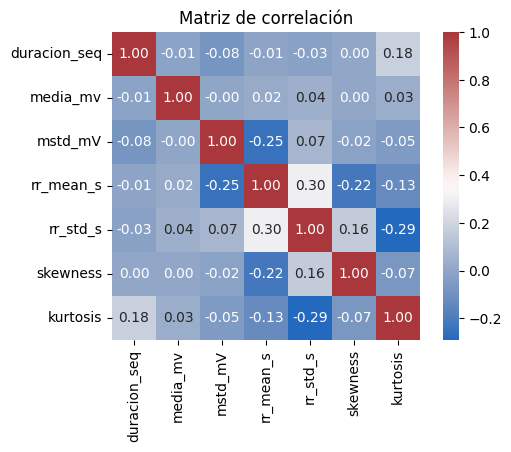

In [27]:
#Mapa de Correlaciones
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
corr = df[['duracion_seq','media_mv','mstd_mV','rr_mean_s','rr_std_s','skewness','kurtosis']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", square=True)
plt.title("Matriz de correlación")
plt.show()


**Revisión:**

Se observa que las características extraídas del conjunto de datos no presentan valores nulos, lo que garantiza la fiabilidad de los datos. La duración de la secuencia muestra variaciones que reflejan la longitud de las señales de los registros, mientras que media_mv y mstd_mV presentan una dispersión significativa, lo que indica diferencias en la amplitud de las señales de los latidos. La asimetría de las señales, medida a través de skewness y kurtosis, muestra una mayor variabilidad en los registros Anormales (afectados por arritmias como la fibrilación auricular) en comparación con los registros Normales. Estas métricas indican que las señales de fibrilación auricular tienen una distribución más sesgada y colas más pronunciadas, lo que es consistente con la fisiología de la arritmia, donde los intervalos de latidos son irregulares.

Por otro lado, la matriz de correlación revela que varias características están relacionadas entre sí, particularmente aquellas que miden la variabilidad del ritmo, como rr_mean_s y rr_std_s. Además, la relación entre skewness y kurtosis indica que las señales con una distribución sesgada tienden a mostrar colas más pronunciadas, lo cual es un patrón común en las señales anormales como las de AFib. Las correlaciones bajas entre otras variables, como duracion_seq, sugieren que la duración de la señal no afecta significativamente las características de variabilidad del ritmo o la forma de la distribución.

Visualizando las distribuciones

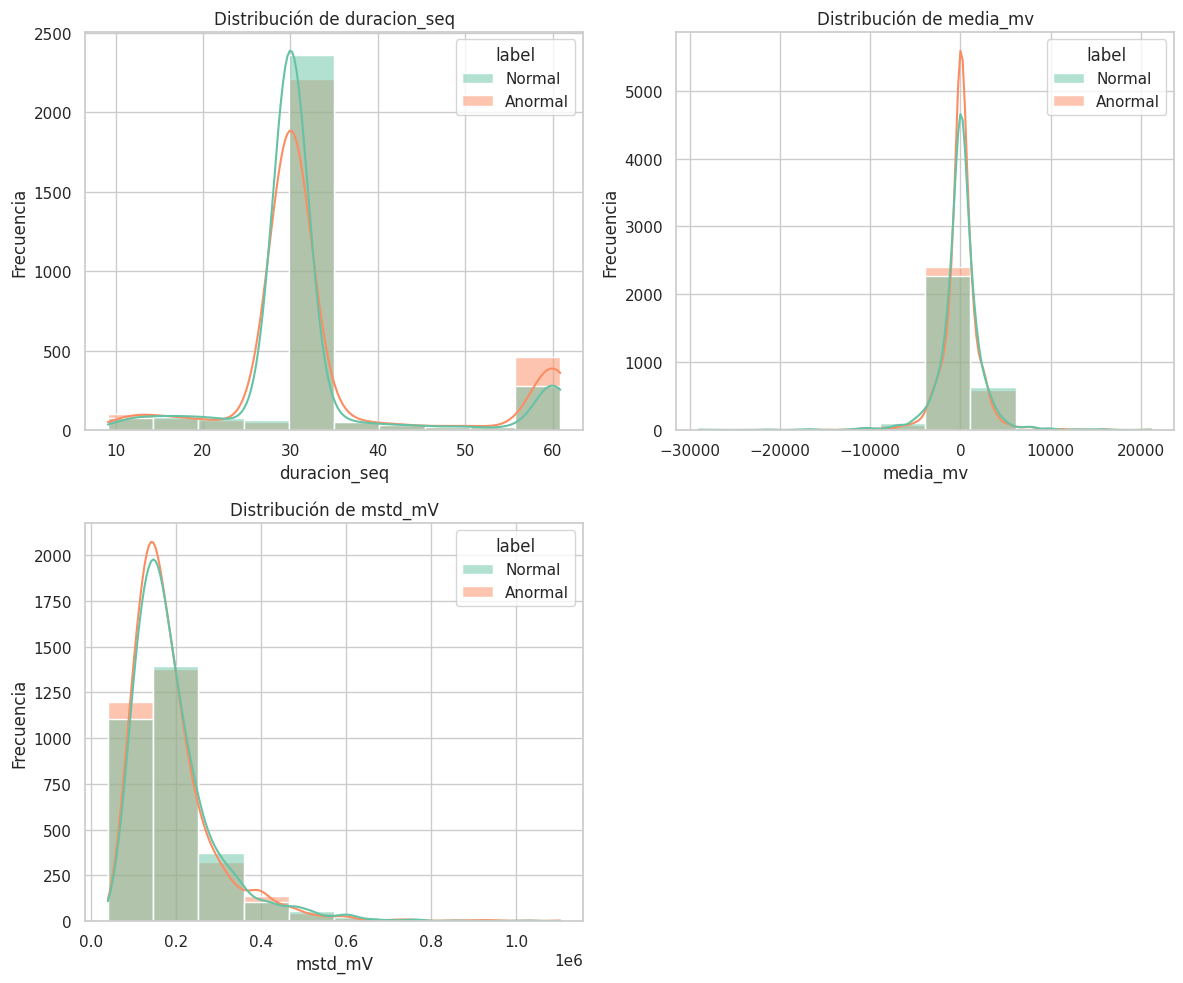

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
features = ['duracion_seq','media_mv','mstd_mV']
palette = {'Normal': '#66c2a5', 'Anormal': '#fc8d62'}

plt.figure(figsize=(12, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    ax = sns.histplot(data=df, x=feature, hue='label', kde=True, palette=palette, bins=10)
    ax.set_title(f"Distribución de {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frecuencia")

    # Obtener leyenda desde los handles y labels reales
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, title="Clase")

plt.tight_layout()
plt.show()


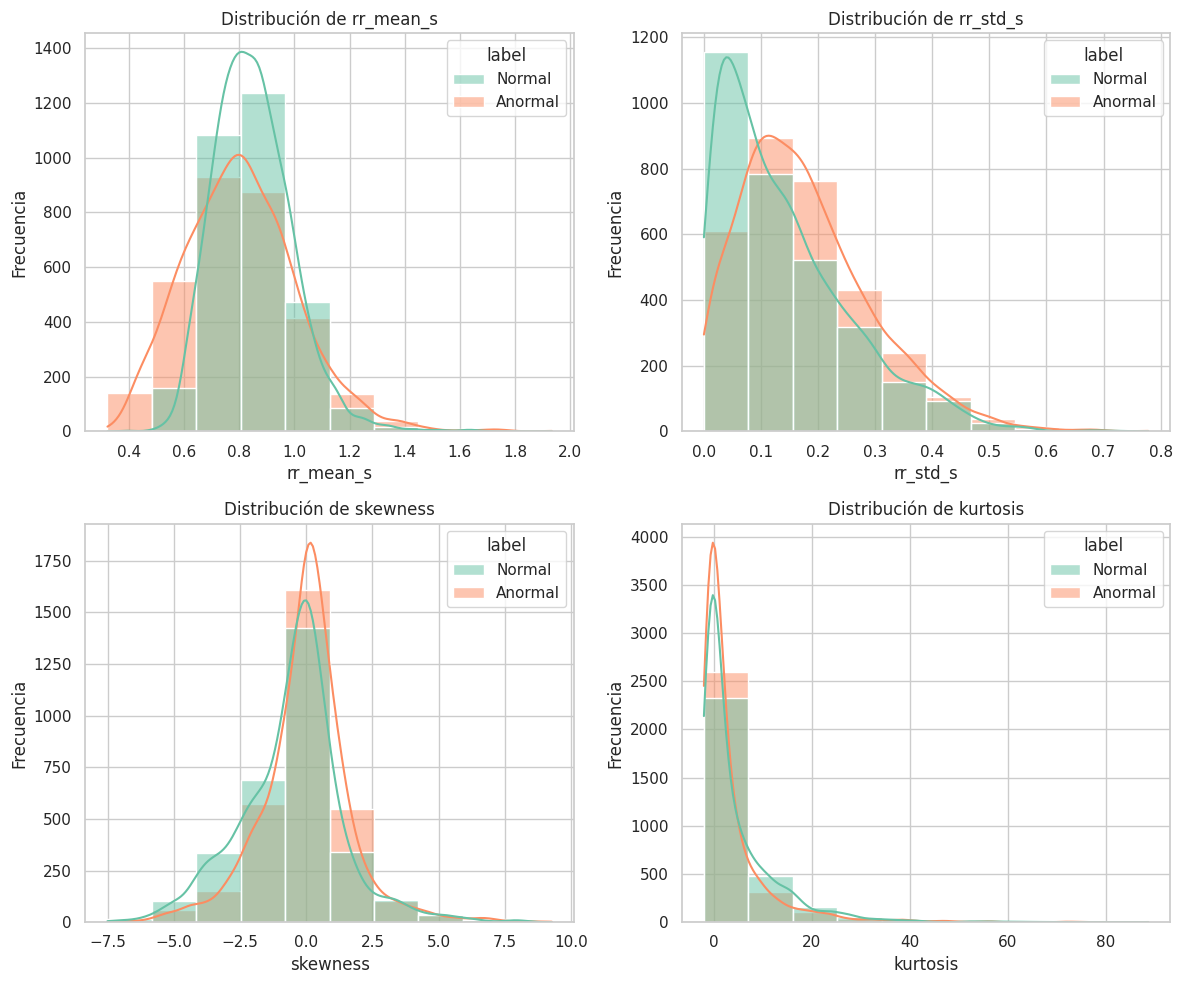

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
features = ['rr_mean_s','rr_std_s','skewness','kurtosis']
palette = {'Normal': '#66c2a5', 'Anormal': '#fc8d62'}

plt.figure(figsize=(12, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    ax = sns.histplot(data=df, x=feature, hue='label', kde=True, palette=palette, bins=10)
    ax.set_title(f"Distribución de {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frecuencia")

    # Obtener leyenda desde los handles y labels reales
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, title="Clase")

plt.tight_layout()
plt.show()


**Interpretación:**

Las distribuciones de los estadísticos derivados de los intervalos RR, en particular rr_mean_s y rr_std_s, muestran una clara diferenciación entre las clases Normal y Anormal. En rr_mean_s, los registros Normales tienden a presentar intervalos RR más largos, lo que está asociado con una frecuencia cardíaca más baja y estable. En contraste, los registros Anormales tienen intervalos RR más irregulares y más cortos, lo que refleja una mayor frecuencia cardíaca y variabilidad en los intervalos de los latidos. La desviación estándar de los intervalos RR (rr_std_s) muestra que los registros Anormales presentan una mayor dispersión entre los intervalos RR, lo que es indicativo de la irregularidad típica de los latidos cardíacos en esta clase. Además, skewness y kurtosis muestran que las señales Anormales tienen una distribución más sesgada y colas más pronunciadas, lo cual es esperado en señales de ritmos irregulares o anómalos.


**Conclusión General:**
El análisis descriptivo y visual de las señales muestra que las métricas derivadas de los intervalos RR, como rr_mean_s y rr_std_s, son efectivas para diferenciar entre los ritmos Normales y Anormales. En particular, la mayor variabilidad en los intervalos RR y la irregularidad en rr_std_s y skewness son características clave que permiten identificar señales anormales. El uso de un filtrado paso banda adecuado ayuda a mejorar la calidad de las métricas extraídas, lo que permite que las diferencias entre clases se hagan más evidentes. Esto resalta la importancia de un buen preprocesamiento de las señales para asegurar que las características extraídas reflejen con precisión la actividad cardíaca.

**¿Qué variables parecen diferenciar más entre clases?**
La variable que más destaca es rr_std_s, ya que muestra una diferencia clara entre las clases: los registros Anormales presentan una mayor dispersión en los intervalos RR, lo cual es característico de la irregularidad del ritmo cardíaco. También destacan, aunque en menor medida, skewness y kurtosis, ya que las señales Anormales tienden a tener distribuciones más asimétricas y con colas más pronunciadas, lo que refleja una mayor irregularidad en los intervalos de latido.

**¿Qué aspectos del dataset llaman la atención?**
Uno de los aspectos más llamativos es la influencia del preprocesamiento en la calidad de las métricas. Sin un adecuado filtrado paso banda, las estadísticas pueden ser engañosas, mostrando incluso más variabilidad en los registros Normales. El análisis también destaca cómo, a pesar de que el número de registros es relativamente pequeño, las diferencias entre las clases Normales y Anormales son claramente visibles, lo que resalta la importancia de realizar un buen preprocesamiento y de extraer características robustas para garantizar un análisis confiable.